In [3]:
PATH = ""

# Scrapping Data

In [4]:
import time
import requests
from bs4 import BeautifulSoup
import csv

# Add headers to the request
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'
}

def write_csv(file_name,keys,data_dict):

    with open(file_name,"w", encoding="utf-8-sig", newline='') as f:
        writer = csv.DictWriter(f,keys,dialect='excel',quoting=csv.QUOTE_ALL)
        writer.writeheader()
        writer.writerows(data_dict)

def read_csv(file_name):
    with open(file_name,"r",encoding="utf-8-sig") as f:
        reader = csv.reader(f)
        header = next(reader)
        links = []
        for link in reader:
            links.append(link[0])
    
    return links

def get_and_write_apt_links():
    links = []
    for i in range(1,9):
        # Set the URL
        url = f'https://www.emlakjet.com/kiralik-konut/istanbul-bahcelievler/{i}/'

        # Send the request 
        response = requests.get(url, headers=headers)

        # Check if the request was successful
        if response.status_code == 200:
            # Parse the HTML content
            soup = BeautifulSoup(response.content, 'html.parser')
            # print(soup.text)

            # Extract the flat details
            flats = soup.find_all('div', class_='_3qUI9q')
            print(len(flats))
            time.sleep(1)
            # Iterate over each flat
            for flat in flats:
                link = "https://www.emlakjet.com"+flat.find('a', class_='_3qUI9q').get('href').strip()
                price = flat.find('p', class_='_2C5UCT').text.strip()
                links.append({"link":link})

                print('Link:', link)
                print('Price:', price)
                print('---')


        else:
            print('Request failed with status code:', response.status_code)
            i -= 1

    keys = ["link"]
    file_name = "apt_links.csv"
    write_csv(file_name,keys,links)

def get_apt_details(url):
    prop_dict = {}
    # Send the request 
    response = requests.get(url, headers=headers)

    # Check if the request was successful
    if response.status_code == 200:
        # Parse the HTML content
        soup = BeautifulSoup(response.content, 'html.parser')

        price = soup.find('div', class_='_2TxNQv').text.split()[0]
        prop_dict["Fiyat"] = price
        
        # Extract the flat details
        props = soup.find_all('div', class_='_35T4WV')
        print(len(props))
        # Iterate over each flat
        for prop in props:
            tmp = prop.find_all('div', class_='_1bVOdb')
            prop_name = tmp[0].text.strip()
            prop_value = tmp[1].text.strip()
            prop_dict[prop_name] = prop_value

    else:
        print('Request failed with status code:', response.status_code)
    
    return prop_dict

def get_and_write_all_apt_data(url_list):
    data_rows = []
    keys = set()
    for url in url_list:
        print(url)
        row = get_apt_details(url)
        data_rows.append(row)
        row_keys = set(row.keys())
        keys = keys.union(row_keys)
        time.sleep(1)
    
    write_csv(PATH+"apt_raw_data.csv",keys,data_rows)


########################################################################
### NOT: burda fonkisyonlar yoruma alindi cunku veri dosyalari hazir ###
########################################################################
# # links = get_and_write_apt_links()
# links = read_csv(PATH+"apt_links.csv")
# # print(links)
# get_and_write_all_apt_data(links)


# Data Preprocessing

In [5]:
import pandas as pd
import re

df = pd.read_csv(PATH+"apt_raw_data.csv")

col_drop = ['Takas', 'Kullanım Durumu', 'İlan Numarası', 'WC Metrekare',
            'Banyo Metrekare', 'Kategorisi', 'Görüntülü Gezilebilir mi?', 'Isıtma Tipi',
            'İlan Oluşturma Tarihi','İlan Güncelleme Tarihi', 'Salon Metrekare',
            'Balkon Tipi', 'Aidat', 'Fiyat Durumu', 'Depozito', 'Balkon Durumu', 'Balkon Metrekare', 'Yapı Tipi', 'Türü']

df = df.drop(columns=col_drop)
df.columns


Index(['Site İçerisinde', 'Eşya Durumu', 'Brüt Metrekare', 'Binanın Yaşı',
       'Net Metrekare', 'WC Sayısı', 'Bulunduğu Kat', 'Yapı Durumu',
       'Oda Sayısı', 'Balkon Sayısı', 'Fiyat', 'Banyo Sayısı',
       'Binanın Kat Sayısı'],
      dtype='object')

In [6]:
for col in df.columns:
    df[col] = df[col].astype('str').str.lower()

In [7]:
# 'WC Sayısı'
df['WC Sayısı'] = df['WC Sayısı'].replace("nan","1")
df['WC Sayısı'] = df['WC Sayısı'].replace("yok","0")

df['WC Sayısı'].unique()

array(['1', '2', '3', '0'], dtype=object)

In [8]:
# 'Eşya Durumu'
df['Eşya Durumu'] = df['Eşya Durumu'].replace("nan","0")
df['Eşya Durumu'] = df['Eşya Durumu'].replace("boş", "0")
df['Eşya Durumu'] = df['Eşya Durumu'].replace("eşyalı", "1")

df['Eşya Durumu'].unique()

array(['0', '1'], dtype=object)

In [9]:
# 'Site İçerisinde'
df['Site İçerisinde'] = df['Site İçerisinde'].replace("nan","0")
df['Site İçerisinde'] = df['Site İçerisinde'].replace("hayır", "0")
df['Site İçerisinde'] = df['Site İçerisinde'].replace("evet", "1")

df['Site İçerisinde'].unique()

array(['0', '1'], dtype=object)

In [10]:
# 'Brüt Metrekare'
df['Brüt Metrekare'] = df['Brüt Metrekare'].str.replace("m2", "")

# 'Net Metrekare'
df['Net Metrekare'] = df['Net Metrekare'].str.replace("m2", "")

In [11]:
# 'Binanın Yaşı'
df['Binanın Yaşı'] = df['Binanın Yaşı'].replace('0 (yeni)', "0")
df['Binanın Yaşı'] = df['Binanın Yaşı'].replace(['4', '3', '1','2'], "1")
df['Binanın Yaşı'] = df['Binanın Yaşı'].replace(['5-10', '10-may'], "2")
df['Binanın Yaşı'] = df['Binanın Yaşı'].replace(['11-15', '15-nov'], "3")
df['Binanın Yaşı'] = df['Binanın Yaşı'].replace('16-20', "4")
df['Binanın Yaşı'] = df['Binanın Yaşı'].replace('21 ve üzeri', "5")

df['Binanın Yaşı'].describe()
df['Binanın Yaşı'].unique()

array(['5', '0', '2', '3', '1', '4'], dtype=object)

In [12]:
# 'Bulunduğu Kat'

def replace_string(row):
    # print(row)
    if re.search(r'\bbahçe\b|\bgiriş\b', row):
        return '0'
    if re.search(r'\bbodrum\b', row):
        return '-1'
    if re.search(r'\bçatı\b', row):
        return 'MAX'
    if re.search(r'\b\.kat\b', row):
        return re.findall("\d+",row)[0]
    if re.search(r'\bkot\b', row):
        return '-'+re.findall("\d+",row)[0]
    return row

df['Bulunduğu Kat'] = df['Bulunduğu Kat'].apply(replace_string)
mode_value = df["Bulunduğu Kat"].mode()[0]
df['Bulunduğu Kat'] = df['Bulunduğu Kat'].replace("nan",mode_value)

df['Bulunduğu Kat'] = df.apply(lambda row: row['Bulunduğu Kat'] if row['Bulunduğu Kat'] != "MAX" else row['Binanın Kat Sayısı'], axis=1)

work = 'Bulunduğu Kat'
df[work].describe()
df[work].unique()

array(['5', '0', '4', '2', '3', '1', '6', '7', '10', '-1', '17', '8',
       '13', '15', '-3', '12'], dtype=object)

In [13]:
# 'Yapı Durumu'
df['Yapı Durumu'] = df['Yapı Durumu'].replace('sıfır', "0")
df['Yapı Durumu'] = df['Yapı Durumu'].replace('i̇kinci el', "1")
df['Yapı Durumu'] = df.apply(lambda row: row['Yapı Durumu'] if row['Yapı Durumu'] != 'nan' else '0' if row['Binanın Yaşı'] == "0" else "1", axis=1)


work = 'Yapı Durumu'
df[work].describe()
df[work].unique()

array(['1', '0'], dtype=object)

In [14]:
# 'Oda Sayısı'
def extract_rooms(row:str):
    # print(row)
    if re.search(r'\b\+\b', row):
        numbers = row.split("+")
        return float(numbers[0]) + float(numbers[1])
    if re.search(r'\boda\b', row):
        return float(re.findall("\d+",row)[0])
    if re.search(r'\bstüdyo\b', row):
        return 1.0
    return "MODE"

df['Oda Sayısı'] = df['Oda Sayısı'].apply(extract_rooms)

work = 'Oda Sayısı'
df[work].describe()
df[work].unique()
# df[work].value_counts(normalize=False)

array([2. , 3. , 4. , 5. , 2.5, 3.5, 1. , 6. ])

In [15]:
# 'Balkon Sayısı'

df['Balkon Sayısı'] = df['Balkon Sayısı'].replace('nan', "1.0")

df['Balkon Sayısı'] = df['Balkon Sayısı'].astype(float).astype(int)

work = 'Balkon Sayısı'
df[work].describe()
df[work].unique()
# df[work].value_counts(normalize=False)

array([1, 2, 3])

In [16]:
# 'Fiyat'
def extract_price(row:str):
    row = row.replace(",","")
    return int(re.findall("\d+",row)[0])

df['Fiyat'] = df['Fiyat'].apply(extract_price)


work = 'Fiyat'
df[work].describe()
df[work].unique()

array([   5000,    8000,   13500,   13750,   13000,   12000,   12700,
          8500,    7900,   10000,   11000,   19000,    7500,    6500,
          9000,    7750,   14000,    8250,    9500,   15000,   32000,
         12500,    7000,   14500,   10500,   17500,    8750,    9750,
          6000,   20000,   17000,    5500,   33000,   24500,   39000,
         16000,    9999,   18000, 3150000,   10300,    4500,   21000,
         15500,  350000,    2500,   27000,   25000,    3000,   11500,
          4000,    7800,    5750,   22000,    7100,   29000,   23500,
         38000,    1500,   30000,    1499], dtype=int64)

In [17]:
# 'Banyo Sayısı'
df['Banyo Sayısı'] = df['Banyo Sayısı'].replace('nan', "1")
df['Banyo Sayısı'] = df['Banyo Sayısı'].replace('yok', "0")

work = 'Banyo Sayısı'
df[work].describe()
df[work].unique()
df[work].value_counts(normalize=False)

Banyo Sayısı
1    205
2     27
3      5
0      3
Name: count, dtype: int64

In [18]:
# 'Binanın Kat Sayısı'
df['Binanın Kat Sayısı'] = df['Binanın Kat Sayısı'].replace('nan', df['Binanın Kat Sayısı'].mode()[0])

work = 'Binanın Kat Sayısı'
df[work].describe()
df[work].unique()
# df[work].value_counts(normalize=False)

array(['5', '4', '6', '7', '3', '13', '9', '8', '12', '18', '14', '16',
       '15', '17', '10', '2'], dtype=object)

In [19]:
# Wrtie Processed data to file
for col in df.columns:
    df[col] = df[col].astype(float)

# df.to_csv(PATH+"apt_pre_data.csv")

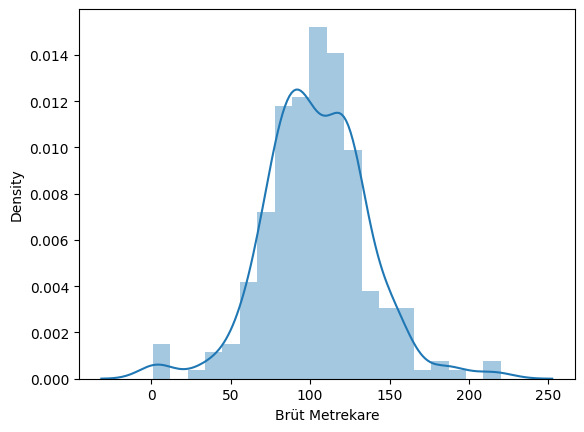

Brüt Metrekare => lower:  6.828350549986666 => upper:  200.58914945001334
prev count:  240
new count:  235


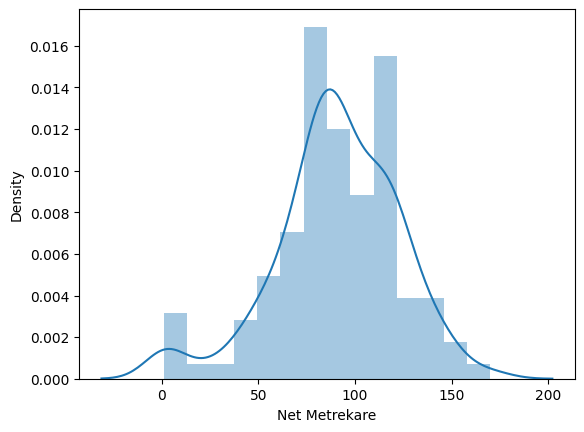

Net Metrekare => lower:  -4.949714764309178 => upper:  186.35397008345814
prev count:  235
new count:  235


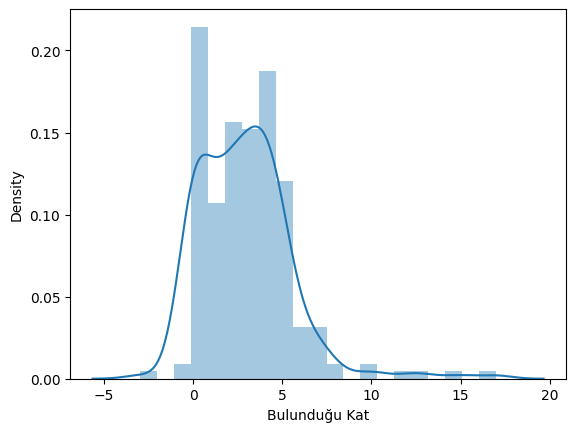

Bulunduğu Kat => lower:  -5.013038171137051 => upper:  10.783250937094499
prev count:  235
new count:  231


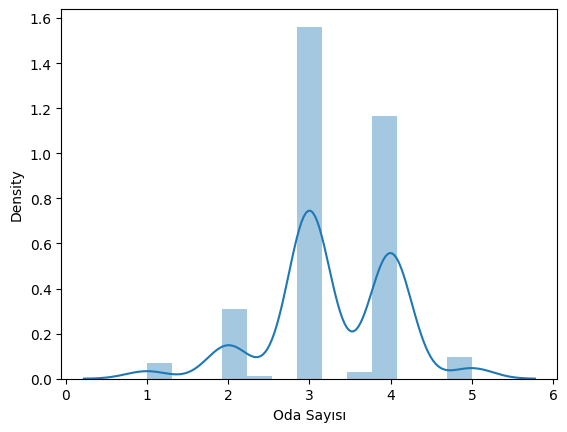

Oda Sayısı => lower:  0.9836467585644835 => upper:  5.583452808535084
prev count:  231
new count:  231


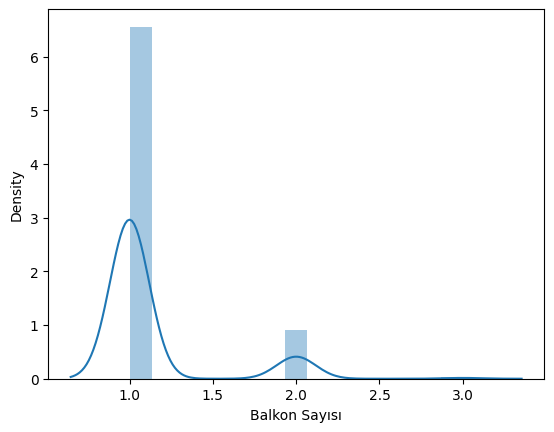

Balkon Sayısı => lower:  0.08119588415284484 => upper:  2.178544375587415
prev count:  231
new count:  230


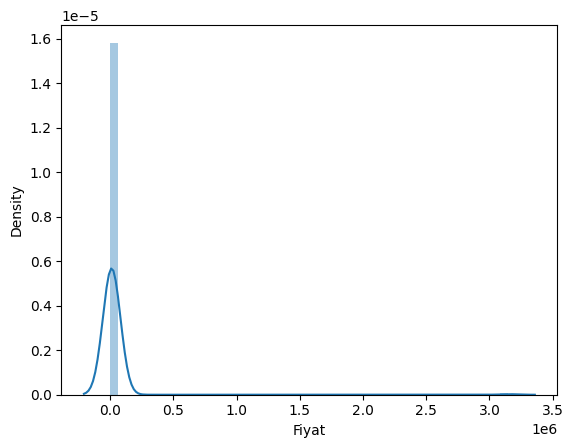

Fiyat => lower:  -181812.56796501382 => upper:  232197.76796501383
prev count:  230
new count:  229


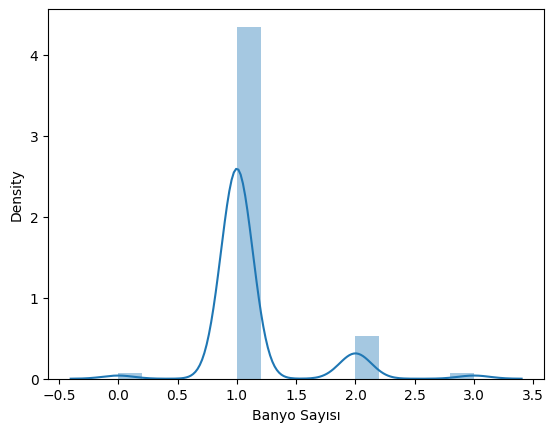

Banyo Sayısı => lower:  -0.07113472213009997 => upper:  2.3069425823921086
prev count:  229
new count:  226


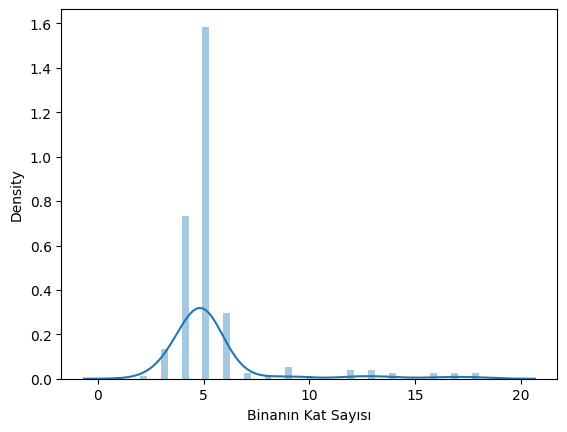

Binanın Kat Sayısı => lower:  -2.3920397269790623 => upper:  13.347791939368443
prev count:  226
new count:  218


In [20]:
# outlier değerleri kaldırma
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

def determine_outlier_thresholds_std(dataframe: pd.DataFrame, col_name):
    dataframe = dataframe.astype(float)
    mul = 3
    if col_name == 'Fiyat':
        mul = 1
    upper_boundary = dataframe[col_name].mean() +  mul * dataframe[col_name].std()
    lower_boundary = dataframe[col_name].mean() -  mul * dataframe[col_name].std()
    return lower_boundary, upper_boundary


cols_to_clean = ['Brüt Metrekare', 'Net Metrekare', 'Bulunduğu Kat', 'Oda Sayısı', 'Balkon Sayısı', 'Fiyat', 'Banyo Sayısı', 'Binanın Kat Sayısı']

df_no_outlier = df # outlier değerlerin çıkarılacağı temizlenmiş veri çerçevesi


for col in cols_to_clean:
    sns.distplot(df_no_outlier[col]) # Sütunun dağılımını görselleştirme
    plt.show()
    lower_bound, upper_bound = determine_outlier_thresholds_std(df_no_outlier,col)
    print(col,"=> lower: ",lower_bound,"=> upper: ",upper_bound)

    print("prev count: ",df_no_outlier[col].count())
    df_no_outlier = df_no_outlier[(df_no_outlier[col] < upper_bound) & (df_no_outlier[col] > lower_bound)]
    print("new count: ",df_no_outlier[col].count())

warnings.filterwarnings('default')


df_no_outlier.to_csv(PATH+"apt_cleaned_data.csv") # Temizlenmiş veriyi CSV dosyasına kaydet

# Build The Models

In [21]:
import numpy as np
from sklearn.model_selection import train_test_split

rand = 217 # Rastgelelik için kullanılacak sabit değer
test_size = 0.20 # Test veri setinin oranı (%20)

print(rand)

y = df['Fiyat']  # Bağımlı değişken (etiket) olarak 'Fiyat' sütununu ayır
x = df.drop(columns=['Fiyat'])  # Bağımsız değişkenleri (özellikler) 'Fiyat' sütununu çıkararak ayır


217


In [22]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler() 
x_normalized = min_max_scaler.fit_transform(x) # Bağımsız değişkenleri Min-Max ölçeklendirme ile normalize et


In [23]:
y_no_out = df_no_outlier['Fiyat']  # Temizlenmiş veri çerçevesindeki 'Fiyat' sütununu bağımlı değişken (etiket) olarak ayır
x_no_out = df_no_outlier.drop(columns=['Fiyat'])  # Temizlenmiş veri çerçevesinden 'Fiyat' sütununu çıkararak bağımsız değişkenleri (özellikler) ayır

x_no_out_normalized = min_max_scaler.fit_transform(x_no_out)  # Temizlenmiş bağımsız değişkenleri Min-Max ölçeklendirme ile normalize et

x_no_out_nor_train, x_no_out_nor_test, y_no_out_nor_train, y_no_out_nor_test = train_test_split(x_no_out_normalized, y_no_out, test_size=test_size,random_state=rand)

In [24]:
from sklearn.decomposition import PCA

pca = PCA(n_components=x_no_out_normalized[0].size)  # PCA (Principal Component Analysis) analizi için bir örnek (nesne) oluştur, bileşen sayısını belirt
x_pca = pca.fit_transform(x_no_out_normalized)  # Normalize edilmiş bağımsız değişkenleri PCA analizine tabi tut ve dönüştür


In [30]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

# Doğrusal Regresyon (Linear Regression) ve Rastgele Orman Regresyonu (Random Forest Regression) modelleri oluştur
l_reg = LinearRegression()
rf_reg = RandomForestRegressor(n_estimators=100)

cv_no = 10  # Çapraz doğrulama (cross-validation) için kat sayısı
scores_avgs = []  # Modellerin ortalama doğruluk skorlarını saklamak için bir liste

# Doğrusal Regresyon Modeli için doğruluk skorunu hesapla ve listeye ekle
score = cross_val_score(l_reg, x, y, cv=cv_no)
scores_avgs.append(score.sum() / cv_no)

# Doğrusal Regresyon Modeli için doğruluk skorunu hesapla ve listeye ekle
score = cross_val_score(l_reg, x_no_out, y_no_out, cv=cv_no)
scores_avgs.append(score.sum() / cv_no)

# Doğrusal Regresyon Modeli için normalize edilmiş verilerle doğruluk skorunu hesapla ve listeye ekle
score = cross_val_score(l_reg, x_no_out_normalized, y_no_out, cv=cv_no)
scores_avgs.append(score.sum() / cv_no)

# Doğrusal Regresyon Modeli için PCA dönüşümü uygulanan verilerle doğruluk skorunu hesapla ve listeye ekle
score = cross_val_score(l_reg, x_pca, y_no_out, cv=cv_no)
scores_avgs.append(score.sum() / cv_no)

# Rastgele Orman Regresyonu Modeli için doğruluk skorunu hesapla ve listeye ekle
score = cross_val_score(rf_reg, x, y, cv=cv_no)
scores_avgs.append(score.sum() / cv_no)

# Rastgele Orman Regresyonu Modeli için doğruluk skorunu hesapla ve listeye ekle
score = cross_val_score(rf_reg, x_no_out, y_no_out, cv=cv_no)
scores_avgs.append(score.sum() / cv_no)

# Rastgele Orman Regresyonu Modeli için normalize edilmiş verilerle doğruluk skorunu hesapla ve listeye ekle
score = cross_val_score(rf_reg, x_no_out_normalized, y_no_out, cv=cv_no)
scores_avgs.append(score.sum() / cv_no)

# Rastgele Orman Regresyonu Modeli için PCA dönüşümü uygulanan verilerle doğruluk skorunu hesapla ve listeye ekle
score = cross_val_score(rf_reg, x_pca, y_no_out, cv=cv_no)
scores_avgs.append(score.sum() / cv_no)

print("score avgs: ",scores_avgs)


score avgs:  [-154.75971450257563, 0.04107929934086539, 0.04107929934086506, 0.041079299340866, -353.3767515985369, -0.06532672069693952, -0.02997648238082822, -0.131303420871914]


In [26]:
from sklearn.metrics import mean_absolute_error

# Veriyi eğitim ve test setlerine ayır
x_no_out_nor_train, x_no_out_nor_test, y_no_out_nor_train, y_no_out_nor_test = train_test_split(x_no_out_normalized, y_no_out, test_size=test_size, random_state=rand)

# Doğrusal Regresyon Modelini eğit
l_reg.fit(x_no_out_nor_train, y_no_out_nor_train)

# Rastgele Orman Regresyonu Modelini eğit
rf_reg.fit(x_no_out_nor_train, y_no_out_nor_train)

# Doğrusal Regresyon Modeliyle tahmin yap ve doğruluk skorunu hesapla
l_y_predict = l_reg.predict(x_no_out_nor_test)
l_score = l_reg.score(x_no_out_nor_test, y_no_out_nor_test)
l_score_mae = mean_absolute_error(y_no_out_nor_test, l_y_predict)

# Rastgele Orman Regresyonu Modeliyle tahmin yap ve doğruluk skorunu hesapla
rf_y_predict = rf_reg.predict(x_no_out_nor_test)
rf_score = rf_reg.score(x_no_out_nor_test, y_no_out_nor_test)
rf_score_mae = mean_absolute_error(y_no_out_nor_test, rf_y_predict)

print(f"linear => score: {l_score}  Fiyatta uzaklasma ortalamasi: {l_score_mae}")
print(f"random forest => score: {rf_score}  Fiyatta uzaklasma ortalamasi: {rf_score_mae}")



linear => score: 0.5882107477584799  Fiyatta uzaklasma ortalamasi: 2177.647115873009
random forest => score: 0.574846739041061  Fiyatta uzaklasma ortalamasi: 2318.3080681818183


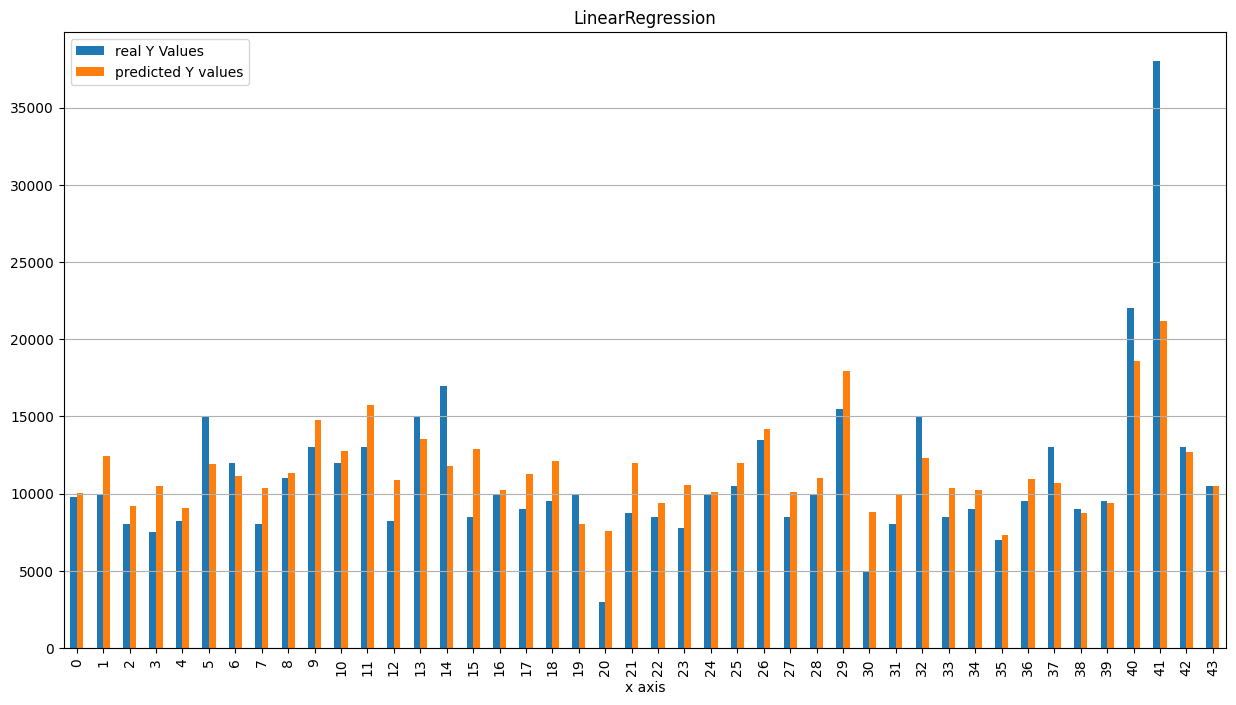

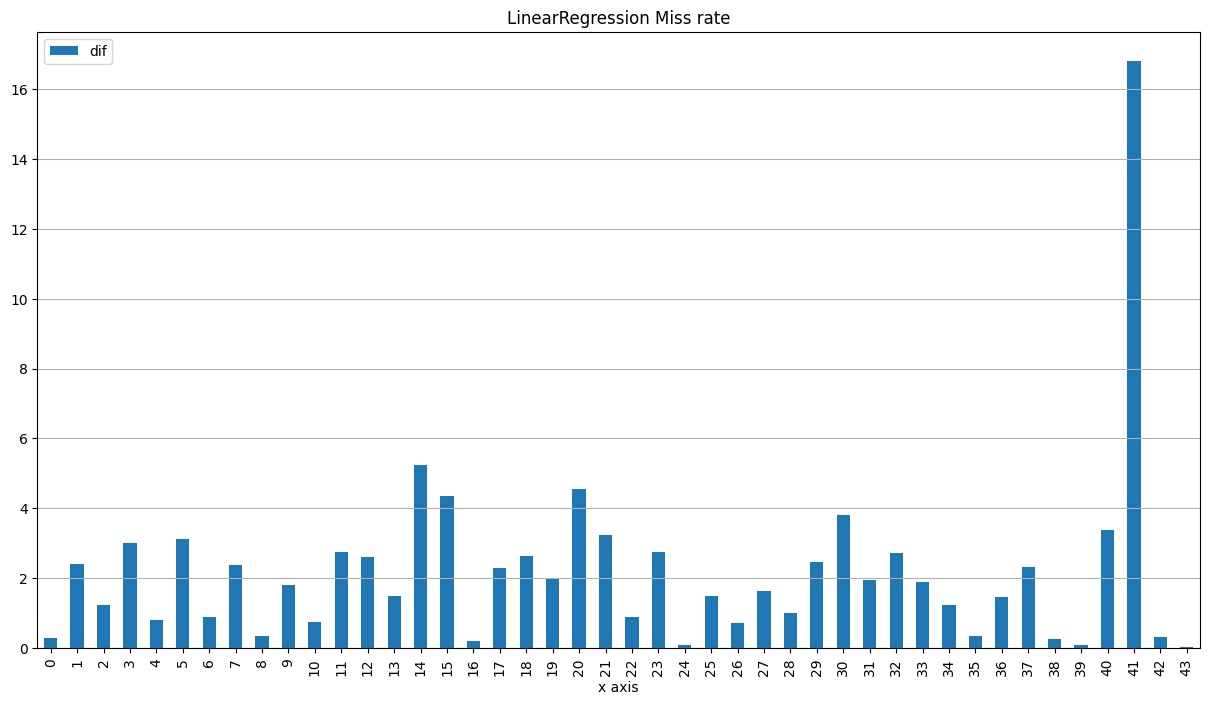

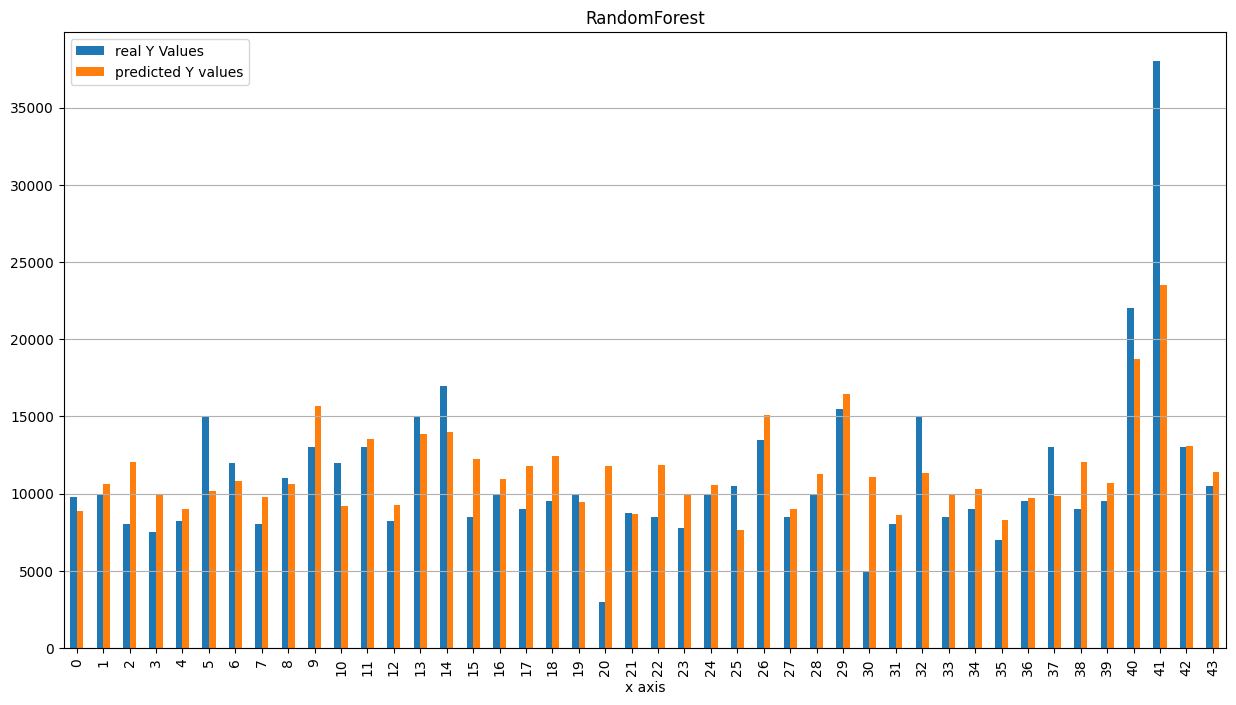

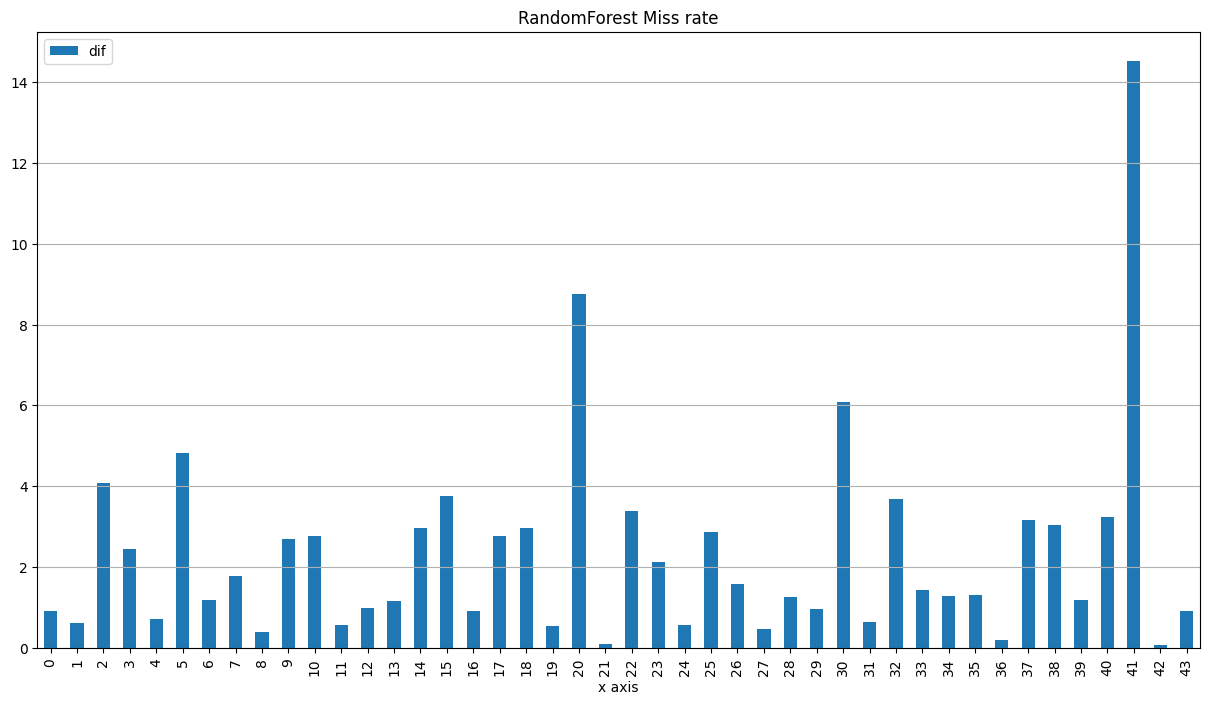

In [27]:
plot_x_test = np.arange(int(y_no_out_nor_test.size))

# LinearRegression
# Gerçek ve tahmin edilen Y değerlerini içeren veri çerçevesi oluştur
all_df = pd.DataFrame({"x axis":plot_x_test,"real Y Values": y_no_out_nor_test,"predicted Y values":l_y_predict, "dif": abs(y_no_out_nor_test-l_y_predict)/1000})
# Gerçek ve tahmin edilen Y değerlerini bar grafiği olarak çizdir
all_df.plot(x="x axis", y=["real Y Values", "predicted Y values"], kind="bar", figsize=(15, 8))
plt.grid(True, axis='y')
plt.title("LinearRegression")
plt.show()

# Hata oranını bar grafiği olarak çizdir
all_df.plot(x="x axis", y=["dif"], kind="bar", figsize=(15, 8))
plt.grid(True, axis='y')
plt.title("LinearRegression Miss rate")
plt.show()

# RandomForest
# Gerçek ve tahmin edilen Y değerlerini içeren veri çerçevesi oluştur
all_df = pd.DataFrame({"x axis": plot_x_test, "real Y Values": y_no_out_nor_test, "predicted Y values": rf_y_predict, "dif": abs(y_no_out_nor_test - rf_y_predict) / 1000})

# Gerçek ve tahmin edilen Y değerlerini bar grafiği olarak çizdir
all_df.plot(x="x axis", y=["real Y Values", "predicted Y values"], kind="bar", figsize=(15, 8))
plt.grid(True, axis='y')
plt.title("RandomForest")
plt.show()

# Hata oranını bar grafiği olarak çizdir
all_df.plot(x="x axis", y=["dif"], kind="bar", figsize=(15, 8))
plt.grid(True, axis='y')
plt.title("RandomForest Miss rate")
plt.show()